## **Sprint 11 - Projeto**

Você trabalha em uma startup que vende produtos alimentícios. Você precisa analisar o comportamento do usuário para o aplicativo da empresa.

Primeiro, estude o funil de vendas. Descubra como os usuários chegam à etapa de compra.  usuários realmente chegam a essa etapa? Quantos ficam presos nas fases anteriores? Quais etapas em particular?

Em seguida, veja os resultados do teste A/A/B. (Continue lendo para obter mais informação sobre os testes A/A/B). Os designers gostariam de alterar as fontes de todo o aplicativo, mas os gerentes temem que os usuários achem o novo design intimidador. Eles decidem tomar a decisão com base nos resultados de um teste A/A/B.

Os usuários são divididos em três grupos: dois grupos de controle recebem as fontes antigas e um grupo de teste recebe as novas. Descubra qual conjunto de fontes produz melhores resultados.

A criação de dois grupos A tem certas vantagens. Podemos adaptar um princípio segundo o qual só estaremos confiantes na precisão de nossos testes quando os dois grupos de controle forem semelhantes. Se houver diferenças significativas entre os grupos A, isso pode nos ajudar a descobrir fatores que podem distorcer os resultados. A comparação de grupos de controle também nos informa de quanto tempo e dados precisaremos ao executar outros testes.

Você usará o mesmo conjunto de dados para análise geral e análise A/A/B. Em projetos reais, os experimentos se realizam constantemente. Os analistas estudam a qualidade de um aplicativo usando dados gerais, sem prestar atenção na participação dos usuários em experimentos.

### **Descrição dos dados**

Cada linha do registro (também referido como log) é uma ação do usuário ou um evento.

EventName — nome do evento
DeviceIDHash — identificador de usuário exclusivo
EventTimestamp — hora do evento
ExpId — número do experimento: 246 e 247 são os grupos de controle, 248 é o grupo de teste

### **Passo 1. Abra o arquivo de dados e leia a informação geral**

#### **Bibliotecas necessárias**

In [1]:
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import datetime as dt
import numpy as np
import scipy.stats as stats 
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest
import math


In [2]:
# Lê o arquivo e separa as colunas
df = pd.read_csv('logs_exp_us.csv', sep= '\t')
df.head()


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [3]:
# Informação gerais do arquivo
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
df.describe()

,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


### **Passo 2. Prepare os dados para análise**
#### **Renomeie as colunas de uma maneira que seja conveniente para você**

In [5]:
# Altera o nome das colunas 
df.columns = ['event_name', 'user_id', 'event_time', 'exp_id']
df.head()

,event_name,user_id,event_time,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


#### **Verifique se há valores ausentes e tipos de dados. Corrija os dados, se necessário**

In [6]:
# Altera a coluna df['event_time'] para datetime
df['event_time'] = pd.to_datetime(df['event_time'], unit='s')


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   event_time  244126 non-null  datetime64[ns]
 3   exp_id      244126 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


In [8]:
# Verificando valores ausentes 
df.isna().sum()

event_name    0
user_id       0
event_time    0
exp_id        0
dtype: int64

#### **Adicione uma coluna de data e hora e uma coluna separada para datas**

In [9]:
# Cria a coluna ['date'] apenas com a data 
df['date'] = df['event_time'].dt.date

In [10]:
df.head()

,event_name,user_id,event_time,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


### **Passo 3. Estude e verifique os dados**

#### **Quantos eventos ficam nos registros?**

In [11]:
# Conta os nomes unívucos dos eventos 
total_events = df['event_name'].nunique()
print(f'Existem {total_events} tipos de eventos')
print()
print(f'São eles: {df['event_name'].unique()}')


Existem 5 tipos de eventos

São eles: ['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']


In [12]:
# Conta quantos eventos aparecem 
events_group = df['event_name'].value_counts().reset_index()
events_group

,event_name,count
0,MainScreenAppear,119205
1,OffersScreenAppear,46825
2,CartScreenAppear,42731
3,PaymentScreenSuccessful,34313
4,Tutorial,1052


In [13]:
# Gráfico de barras 

fig = px.bar(
    events_group,
    x="event_name",
    y="count",
    color="event_name",
    text="count",                   
    color_discrete_sequence = px.colors.sequential.Teal[::-1]  
)

# Ajustar layout
fig.update_layout(
    xaxis_title="Evento",
    yaxis_title="Quantidade",
    title="Quantidade de evento pos categora",
    
    plot_bgcolor="#f8f7f3",     # fundo da área de plotagem
    paper_bgcolor="#f8f7f3",    # fundo geral do gráfico
    font=dict(color="black"),    # cor das fontes
    xaxis=dict(gridcolor="gray"),
    yaxis=dict(gridcolor="gray")
)

fig.show()

#### **Quantos usuários ficam nos registros?**

In [14]:
# Total de usuários 
total_users = df['user_id'].nunique()
print(f'Total de usuários: {total_users}')

Total de usuários: 7551


#### **Qual é o número médio de eventos por usuário?**

In [15]:
# Calcula a quantidade de eventos por usuário
events_user = df.groupby('user_id')['event_name'].count().reset_index()
events_user

,user_id,event_name
0,6888746892508752,1
1,6909561520679493,5
2,6922444491712477,47
3,7435777799948366,6
4,7702139951469979,137
...,...,...
7546,9217594193087726423,9
7547,9219463515465815368,17
7548,9220879493065341500,7
7549,9221926045299980007,7


In [16]:
# Calcula a média de eventos 
mean_events = events_user['event_name'].mean()
mean_events

32.33028737915508

#### **Qual é o período de tempo que os dados cobrem? Encontre as datas máxima e mínima. Desenhe um histograma por data e hora.**

In [17]:
min_date = df['date'].min()
min_date

datetime.date(2019, 7, 25)

In [18]:
max_date = df['date'].max()
max_date

datetime.date(2019, 8, 7)

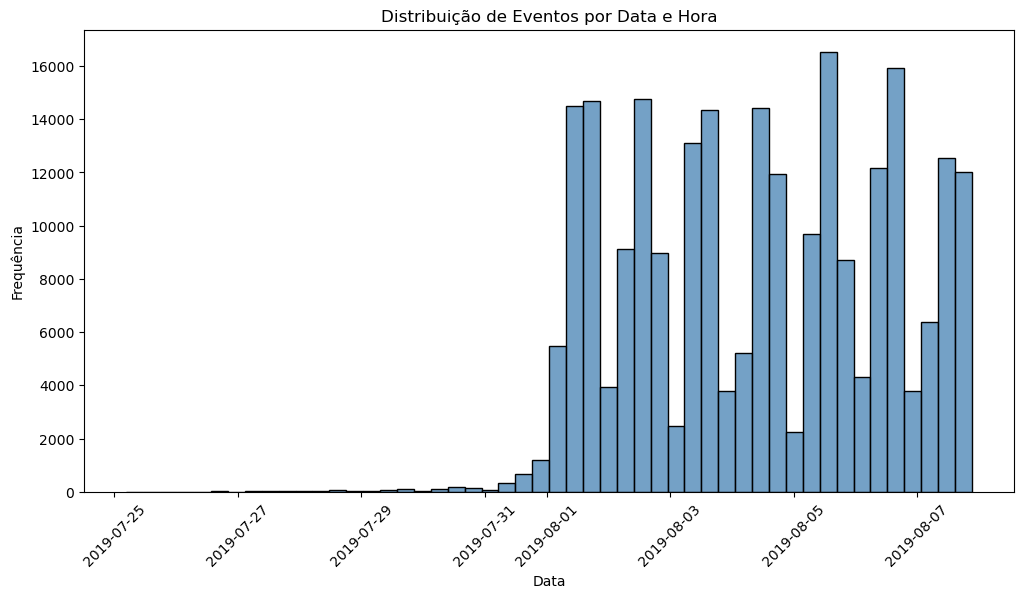

In [19]:

plt.figure(figsize=(12,6))
sns.histplot(
    data=df,
    x="event_time",
    bins=50,           # número de intervalos
    color="steelblue"       # azul sólido
)

plt.xlabel("Data")
plt.ylabel("Frequência")
plt.title("Distribuição de Eventos por Data e Hora")
plt.xticks(rotation=45)
plt.show()

#### **Você pode ter certeza de que possui os dados igualmente completos para todo o período?**

Os dados parecem não estar completos. No início do período até o início de agosto, o gráfico aprensenta valores muito baixos comparado com o restante do período. 

#### **Os eventos mais antigos podem acabar aparecendo nos diários de alguns usuários por motivos técnicos, e isso pode distorcer o quadro geral. Encontre o momento em que os dados começam a ser completos e ignore a seção anterior. Qual período os dados realmente representam?**

In [20]:
df.head()

,event_name,user_id,event_time,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [21]:
# Verifica se a coluna ['date'] está no formato datetime
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   event_time  244126 non-null  datetime64[ns]
 3   exp_id      244126 non-null  int64         
 4   date        244126 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB


In [22]:
# Converte a coluna ['date'] para o formato formato datetime

df['date'] = pd.to_datetime(df['date'])

In [23]:
# Verfica se as colunas estão no formato correto
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   event_time  244126 non-null  datetime64[ns]
 3   exp_id      244126 non-null  int64         
 4   date        244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


In [24]:
# Seleciona apenas o período entre 01 e 07 de agosto
df_filtered = df[df['date'] >= pd.to_datetime('2019-08-01')]
df_filtered.head()

,event_name,user_id,event_time,exp_id,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


#### **Você perdeu muitos eventos e usuários ao excluir os dados mais antigos?**

In [25]:
# Verifica a quantidade de eventos no df_filtered
filtered_events_group = df_filtered['event_name'].value_counts().reset_index()
filtered_events_group

,event_name,count
0,MainScreenAppear,117431
1,OffersScreenAppear,46350
2,CartScreenAppear,42365
3,PaymentScreenSuccessful,34113
4,Tutorial,1039


In [26]:
# Total de usuários 
filtered_users = df_filtered['user_id'].nunique()
print(f'Total de usuários - df_filtered: {filtered_users}')

Total de usuários - df_filtered: 7534


##### **Comentário**
No df original haviam 7551 usuários e após selecionar o período de tempo correto, os usuários caíram para 7534, o que não é uma perda significativa. No gráfico, podemos ver que também não houve diferença significativa na frequência dos eventos. 

#### **Certifique-se de ter usuários de todos os três grupos experimentais.**

In [27]:
df_filtered.head()

,event_name,user_id,event_time,exp_id,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


In [28]:
# Calcula o número de usuários em cada grupo experimental
exp_filtered = df_filtered.groupby('exp_id')['user_id'].nunique().reset_index()
exp_filtered

,exp_id,user_id
0,246,2484
1,247,2513
2,248,2537


### **Passo 4. Estude o funil de eventos**

#### **Veja quais eventos estão nos diários e sua frequência de ocorrência. Classifique-os por frequência.**

In [29]:
# Cria uma coluna nova em cada df para diferenciar os dados originais dos filtrados
filtered_events_group['group'] = 'Filtered'
events_group['group'] = 'Total'

# junta os dois dfs
df_concat = pd.concat([filtered_events_group, events_group])

In [30]:
# gráfico de barras lado a lado
fig = px.bar(
    df_concat,
    x="event_name",
    y="count",
    color="group",
    text='count',
    barmode="group",   # sobrepostos
    color_discrete_map= {"Filtered": "#1481b0", "Total": "#76cdf1"}
)

# Ajustar layout
fig.update_layout(
    xaxis_title="Evento",
    yaxis_title="Quantidade",
    title="Quantidade de evento por categoria",
    
    plot_bgcolor="#f8f7f3",     # fundo da área de plotagem
    paper_bgcolor="#f8f7f3",    # fundo geral do gráfico
    font=dict(color="black"),    # cor das fontes
    xaxis=dict(gridcolor="gray"),
    yaxis=dict(gridcolor="gray")
)

fig.show()

#### **Encontre o número de usuários que executaram cada uma dessas ações. Ordene os eventos pelo número de usuários. Calcule a proporção de usuários que executaram a ação pelo menos uma vez.**

In [31]:
# Calcula quantos usuários executaram cada tipo de evento
filtered_users_events = df_filtered.groupby('event_name')['user_id'].nunique().reset_index().sort_values(by='user_id', ascending=False)
filtered_users_events

,event_name,user_id
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


#### **Em que ordem você acha que as ações ocorreram? Todos elas fazem parte de uma única sequência? Você não precisa levá-las em consideração ao calcular o funil.**




**A - MainScreenAppear** – Tela principal que o usuário visita várias vezes, possivelmente antes ou depois do carrinho.

**B - OffersScreenAppear** – Visualização de ofertas ou promoções, geralmente após explorar o app.

**C - CartScreenAppear** – O usuário começa a explorar ou adicionar algo ao carrinho.

**D - PaymentScreenSuccessful** – Finalização da compra.

**E - Tutorial** – geralmente é a primeira interação de um novo usuário que gerlamente eles pulam. 


#### **Use o funil de eventos para encontrar a parcela de usuários que passam de uma etapa para a próxima (por exemplo, para a sequência de eventos A → B → C, calcule a proporção de usuários na etapa B para o número de usuários na etapa A e a proporção de usuários na etapa C para o número na etapa B).**

In [32]:
filtered_users_events.head()

,event_name,user_id
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [33]:
#Calculando a porcentagem


users = filtered_users_events['user_id'].tolist()
event_name = filtered_users_events['event_name'].tolist()

# Total
total = 7419

# Mostrar porcentagens diretamente
for cat, val in zip(event_name, users):
    print(f"{cat}: {val/total*100:.2f}%")

MainScreenAppear: 100.00%
OffersScreenAppear: 61.91%
CartScreenAppear: 50.33%
PaymentScreenSuccessful: 47.70%
Tutorial: 11.32%


#### **Em qual fase você perde mais usuários?**

A fase que mais se perde usuários é a segunda, OffersScreenAppear, que cais aproximadamente 40%. 

#### **Qual é a parcela de usuários que faz o caminho inteiro, desde o primeiro evento até o pagamento?**

A porcentagem de usuários que chegaram até o pagamento foi de 47.70%. 

### **Passo 5. Estude os resultados do experimento**

#### **Quantos usuários há em cada grupo?**

In [34]:
df_filtered.head()

,event_name,user_id,event_time,exp_id,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


In [35]:
# Conta quantos usuários tem em cada grupo 
exp_users = df_filtered.groupby('exp_id')['user_id'].nunique().reset_index()
exp_users.columns = ['exp_id', 'total_users']
exp_users

,exp_id,total_users
0,246,2484
1,247,2513
2,248,2537


#### **Temos dois grupos de controle no teste A/A, no qual verificamos nossos mecanismos e cálculos. Veja se há uma diferença estatisticamente significativa entre as amostragens 246 e 247.**

In [36]:
# Teste t 246 e 247
# H0 = As amostras são iguais 
# H1 = As amostras são diferentes

# número de usuários em cada grupo
n_246 = df_filtered.groupby([df_filtered['exp_id']== 246])['user_id'].nunique()
n_247 = df_filtered.groupby([df_filtered['exp_id']== 247])['user_id'].nunique()

alpha = 0.05 

if n_246.var() == n_247.var():
    results = st.ttest_ind(n_246, n_247, equal_var=True)
else:
    results = st.ttest_ind(n_246, n_247, equal_var=False)

results = st.ttest_ind(n_246, n_247, equal_var=False) #equal_var=False: Deixa as amostras com o mesmo tamanho

print('valor-p: ', results.pvalue)

if (results.pvalue < alpha):
    print("Rejeitamos a hipótese nula")
else:
    print("Não podemos rejeitar a hipótese nula")


valor-p:  1.0
Não podemos rejeitar a hipótese nula


#### **Selecione o evento mais popular. Em cada um dos grupos de controle, encontre o número de usuários que realizaram essa ação. Encontre a proporção deles. Verifique se a diferença entre os grupos é estatisticamente significativa. Repita o procedimento para todos os outros eventos (economizará tempo se você criar uma função especial para este teste). Você pode confirmar se os grupos foram divididos corretamente?**

In [37]:
# Identifica o evento mais popular 
popular_event = df_filtered['event_name'].value_counts()
popular_event

event_name
MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: count, dtype: int64

In [38]:
print(f'O evento mais popular é o MainScreenAppear, com 117431 o corrências')

O evento mais popular é o MainScreenAppear, com 117431 o corrências


In [39]:
# Identifica o quantidade de usuários para cada envento nos 3 grupos 

df_246 = df_filtered[df_filtered['exp_id'] == 246]
users_event_246 = df_246.groupby('event_name')['user_id'].nunique().reset_index()
users_event_246.columns = ['event_name', 'total_users']
users_event_246

,event_name,total_users
0,CartScreenAppear,1266
1,MainScreenAppear,2450
2,OffersScreenAppear,1542
3,PaymentScreenSuccessful,1200
4,Tutorial,278


In [40]:
# Função - Calcula o total de usuários por evento
def users_event_by_group(df, exp_id):
    df_group = df[df['exp_id'] == exp_id]
    users_event = (
        df_group.groupby('event_name')['user_id']
        .nunique()
        .reset_index()
        .rename(columns={'user_id': 'total_users'})
    )
    return users_event

In [41]:
# Grupo 246 - Total de usuários por evento
users_event_246 = users_event_by_group(df_filtered, 246)
users_event_246.head()

,event_name,total_users
0,CartScreenAppear,1266
1,MainScreenAppear,2450
2,OffersScreenAppear,1542
3,PaymentScreenSuccessful,1200
4,Tutorial,278


In [42]:
# Grupo 249 - Total de usuários por evento
users_event_247 = users_event_by_group(df_filtered, 247)
users_event_247.head()

,event_name,total_users
0,CartScreenAppear,1238
1,MainScreenAppear,2476
2,OffersScreenAppear,1520
3,PaymentScreenSuccessful,1158
4,Tutorial,283


In [43]:
# Grupo 248 - Total de usuários por evento
users_event_248 = users_event_by_group(df_filtered, 248)
users_event_248.head()

,event_name,total_users
0,CartScreenAppear,1230
1,MainScreenAppear,2493
2,OffersScreenAppear,1531
3,PaymentScreenSuccessful,1181
4,Tutorial,279


In [44]:
users_by_event = users_event_246.merge(users_event_247, on='event_name', how='outer')
users_by_event = users_by_event.merge(users_event_248, on='event_name', how='outer')
users_by_event.columns = ['event_name', 'total_users_246', 'total_users_247', 'total_users_248']
users_by_event

,event_name,total_users_246,total_users_247,total_users_248
0,CartScreenAppear,1266,1238,1230
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


In [45]:
# Deixa o df em order decrescente 
users_by_event = users_by_event.sort_values(by='total_users_246', ascending=False)
users_by_event.head()

,event_name,total_users_246,total_users_247,total_users_248
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
0,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


In [46]:
# porcentagem 
def porcent_users_by_event(df):
    users = df['total_users'].tolist() 
    event_name = df['event_name'].tolist()
    total_users = df['total_users'].sum()  # soma o total de usuários

    for cat, val in zip(event_name, users):
        print(f"{cat}: {val/total_users*100:.2f}%")

In [47]:
# Porcentagem exp 246
porcent_users_by_event(users_event_246)

CartScreenAppear: 18.79%
MainScreenAppear: 36.37%
OffersScreenAppear: 22.89%
PaymentScreenSuccessful: 17.81%
Tutorial: 4.13%


In [48]:
# Porcentagem exp 247
porcent_users_by_event(users_event_247)

CartScreenAppear: 18.55%
MainScreenAppear: 37.09%
OffersScreenAppear: 22.77%
PaymentScreenSuccessful: 17.35%
Tutorial: 4.24%


In [49]:
# Porcentagem exp 248
porcent_users_by_event(users_event_248)

CartScreenAppear: 18.32%
MainScreenAppear: 37.13%
OffersScreenAppear: 22.80%
PaymentScreenSuccessful: 17.59%
Tutorial: 4.16%


In [50]:
# h0 = As proporções entre os grupos são diferentes 
# H1 = Não há diferença entre as proporções.

# Função
def t_test(successes1, successes2, trial1, trial2, alpha=0.05):
    # proporção de sucesso do grupo 1
    p1 = successes1/trial1 

    # proporção de sucesso do grupo 2
    p2 = successes2/trial2

    # combinação das proporções
    p_combined = (successes1 + successes2) / (trial1 + trial2)

    # diferença das proporções
    difference = p1 - p2
    
    # Calculando z_values
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trial1 + 1/trial2))

    # definindo distribuição normal padrão (média = 0, desvio padrão = 1)
    distr = stats.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Rejeitamos a hipótese nula: Há uma diferença significativa entre as proporções.")
    else:
        print("Não rejeitamos a hipótese nula: Não há diferença significativa entre as proporções") 

##### **Teste t - MainScreenAppear**

###### **Grupo 246 e 247**

In [51]:
t_test(users_by_event.loc[users_by_event['event_name'] == 'MainScreenAppear', 'total_users_246'].values[0],
        users_by_event.loc[users_by_event['event_name'] == 'MainScreenAppear', 'total_users_247'].values[0],
        exp_users.loc[exp_users['exp_id'] == 246, 'total_users'].values[0],
        exp_users.loc[exp_users['exp_id'] == 247, 'total_users'].values[0],
                ) 

p-value:  0.7570597232046099
Não rejeitamos a hipótese nula: Não há diferença significativa entre as proporções


##### **Teste t - OffersScreenAppear**

###### **Grupo 246 e 247**

In [52]:
t_test(users_by_event.loc[users_by_event['event_name'] == 'OffersScreenAppear', 'total_users_246'].values[0],
        users_by_event.loc[users_by_event['event_name'] == 'OffersScreenAppear', 'total_users_247'].values[0],
        exp_users.loc[exp_users['exp_id'] == 246, 'total_users'].values[0],
        exp_users.loc[exp_users['exp_id'] == 247, 'total_users'].values[0],
                ) 

p-value:  0.2480954578522181
Não rejeitamos a hipótese nula: Não há diferença significativa entre as proporções


##### **Teste t - CartScreenAppear**

###### **Grupo 246 e 247**

In [53]:
t_test(users_by_event.loc[users_by_event['event_name'] == 'CartScreenAppear', 'total_users_246'].values[0],
        users_by_event.loc[users_by_event['event_name'] == 'CartScreenAppear', 'total_users_247'].values[0],
        exp_users.loc[exp_users['exp_id'] == 246, 'total_users'].values[0],
        exp_users.loc[exp_users['exp_id'] == 247, 'total_users'].values[0],
                ) 

p-value:  0.22883372237997213
Não rejeitamos a hipótese nula: Não há diferença significativa entre as proporções


##### **Teste t - PaymentScreenSuccessful**

###### **Grupo 246 e 247**

In [54]:
t_test(users_by_event.loc[users_by_event['event_name'] == 'PaymentScreenSuccessful', 'total_users_246'].values[0],
        users_by_event.loc[users_by_event['event_name'] == 'PaymentScreenSuccessful', 'total_users_247'].values[0],
        exp_users.loc[exp_users['exp_id'] == 246, 'total_users'].values[0],
        exp_users.loc[exp_users['exp_id'] == 247, 'total_users'].values[0],
                ) 

p-value:  0.11456679313141849
Não rejeitamos a hipótese nula: Não há diferença significativa entre as proporções


##### **Teste t - Tutorial**

###### **Grupo 246 e 247**

In [55]:
t_test(users_by_event.loc[users_by_event['event_name'] == 'Tutorial', 'total_users_246'].values[0],
        users_by_event.loc[users_by_event['event_name'] == 'Tutorial', 'total_users_247'].values[0],
        exp_users.loc[exp_users['exp_id'] == 246, 'total_users'].values[0],
        exp_users.loc[exp_users['exp_id'] == 247, 'total_users'].values[0],
                ) 

p-value:  0.9376996189257114
Não rejeitamos a hipótese nula: Não há diferença significativa entre as proporções


#### **Faça a mesma coisa para o grupo com fontes alteradas. Compare os resultados com os de cada um dos grupos de controle para cada evento isoladamente. Compare os resultados com os resultados combinados para os grupos de controle. Quais conclusões você pode tirar do experimento?**

##### **Teste t - MainScreenAppear**

###### **Grupo 248 e 246**

In [56]:
t_test(users_by_event.loc[users_by_event['event_name'] == 'MainScreenAppear', 'total_users_248'].values[0],
        users_by_event.loc[users_by_event['event_name'] == 'MainScreenAppear', 'total_users_246'].values[0],
        exp_users.loc[exp_users['exp_id'] == 248, 'total_users'].values[0],
        exp_users.loc[exp_users['exp_id'] == 246, 'total_users'].values[0],
                ) 

p-value:  0.2949721933554552
Não rejeitamos a hipótese nula: Não há diferença significativa entre as proporções


###### **Grupo 248 e 247**

In [57]:
t_test(users_by_event.loc[users_by_event['event_name'] == 'MainScreenAppear', 'total_users_248'].values[0],
        users_by_event.loc[users_by_event['event_name'] == 'MainScreenAppear', 'total_users_247'].values[0],
        exp_users.loc[exp_users['exp_id'] == 248, 'total_users'].values[0],
        exp_users.loc[exp_users['exp_id'] == 247, 'total_users'].values[0],
                ) 

p-value:  0.4587053616621515
Não rejeitamos a hipótese nula: Não há diferença significativa entre as proporções


##### **Teste t - OffersScreenAppear**

###### **Grupo 248 e 246**

In [58]:
t_test(users_by_event.loc[users_by_event['event_name'] == 'OffersScreenAppear', 'total_users_248'].values[0],
        users_by_event.loc[users_by_event['event_name'] == 'OffersScreenAppear', 'total_users_246'].values[0],
        exp_users.loc[exp_users['exp_id'] == 248, 'total_users'].values[0],
        exp_users.loc[exp_users['exp_id'] == 246, 'total_users'].values[0],
                ) 

p-value:  0.20836205402738917
Não rejeitamos a hipótese nula: Não há diferença significativa entre as proporções


###### **Grupo 248 e 247**

In [59]:
t_test(users_by_event.loc[users_by_event['event_name'] == 'OffersScreenAppear', 'total_users_248'].values[0],
        users_by_event.loc[users_by_event['event_name'] == 'OffersScreenAppear', 'total_users_247'].values[0],
        exp_users.loc[exp_users['exp_id'] == 248, 'total_users'].values[0],
        exp_users.loc[exp_users['exp_id'] == 247, 'total_users'].values[0],
                ) 

p-value:  0.9197817830592261
Não rejeitamos a hipótese nula: Não há diferença significativa entre as proporções


##### **Teste t - CartScreenAppear**

###### **Grupo 248 e 246**

In [60]:
t_test(users_by_event.loc[users_by_event['event_name'] == 'CartScreenAppear', 'total_users_248'].values[0],
        users_by_event.loc[users_by_event['event_name'] == 'CartScreenAppear', 'total_users_246'].values[0],
        exp_users.loc[exp_users['exp_id'] == 248, 'total_users'].values[0],
        exp_users.loc[exp_users['exp_id'] == 246, 'total_users'].values[0],
                ) 

p-value:  0.07842923237520116
Não rejeitamos a hipótese nula: Não há diferença significativa entre as proporções


###### **Grupo 248 e 247**

In [61]:
t_test(users_by_event.loc[users_by_event['event_name'] == 'CartScreenAppear', 'total_users_248'].values[0],
        users_by_event.loc[users_by_event['event_name'] == 'CartScreenAppear', 'total_users_247'].values[0],
        exp_users.loc[exp_users['exp_id'] == 248, 'total_users'].values[0],
        exp_users.loc[exp_users['exp_id'] == 247, 'total_users'].values[0],
                ) 

p-value:  0.5786197879539783
Não rejeitamos a hipótese nula: Não há diferença significativa entre as proporções


##### **Teste t - PaymentScreenSuccessful**

###### **Grupo 248 e 246**

In [62]:
t_test(users_by_event.loc[users_by_event['event_name'] == 'PaymentScreenSuccessful', 'total_users_248'].values[0],
        users_by_event.loc[users_by_event['event_name'] == 'PaymentScreenSuccessful', 'total_users_246'].values[0],
        exp_users.loc[exp_users['exp_id'] == 248, 'total_users'].values[0],
        exp_users.loc[exp_users['exp_id'] == 246, 'total_users'].values[0],
                ) 

p-value:  0.2122553275697796
Não rejeitamos a hipótese nula: Não há diferença significativa entre as proporções


###### **Grupo 248 e 247**

In [63]:
t_test(users_by_event.loc[users_by_event['event_name'] == 'PaymentScreenSuccessful', 'total_users_248'].values[0],
        users_by_event.loc[users_by_event['event_name'] == 'PaymentScreenSuccessful', 'total_users_247'].values[0],
        exp_users.loc[exp_users['exp_id'] == 248, 'total_users'].values[0],
        exp_users.loc[exp_users['exp_id'] == 247, 'total_users'].values[0],
                ) 

p-value:  0.7373415053803964
Não rejeitamos a hipótese nula: Não há diferença significativa entre as proporções


##### **Teste t - Tutorial**

###### **Grupo 248 e 246**

In [64]:
t_test(users_by_event.loc[users_by_event['event_name'] == 'Tutorial', 'total_users_248'].values[0], 
        users_by_event.loc[users_by_event['event_name'] == 'Tutorial', 'total_users_246'].values[0],
        exp_users.loc[exp_users['exp_id'] == 248, 'total_users'].values[0],
        exp_users.loc[exp_users['exp_id'] == 246, 'total_users'].values[0],
                ) 

p-value:  0.8264294010087645
Não rejeitamos a hipótese nula: Não há diferença significativa entre as proporções


###### **Grupo 248 e 247**

In [65]:
t_test(users_by_event.loc[users_by_event['event_name'] == 'Tutorial', 'total_users_248'].values[0],
        users_by_event.loc[users_by_event['event_name'] == 'Tutorial', 'total_users_247'].values[0],
        exp_users.loc[exp_users['exp_id'] == 248, 'total_users'].values[0],
        exp_users.loc[exp_users['exp_id'] == 247, 'total_users'].values[0],
                ) 

p-value:  0.765323922474501
Não rejeitamos a hipótese nula: Não há diferença significativa entre as proporções


#### **Qual nível de significância você definiu para testar as hipóteses estatísticas mencionadas acima? Calcule quantos testes de hipóteses estatísticas você realizou. Com um nível de significância estatística de 0,1, um de cada 10 resultados pode ser falso. Qual deveria ser o nível de significância? Se você quiser alterá-lo, execute as etapas anteriores novamente e verifique suas conclusões.**

O nível de significância utilizado nos testes foi de alpha = 0.05. 

No total, foram feitos 15 testes de hipóteses. 

Após a realização de 15 testes de hipóteses entre as proporções dos três grupos, todos os resultados apresentaram p-values elevados (variando de 0.11 a 0.93). Isso indica que não há evidências estatísticas para rejeitar a hipótese nula em nenhum dos casos. Portanto, concluímos que as proporções dos três grupos não diferem de forma significativa, ou seja, o comportamento observado é estatisticamente semelhante entre eles dentro do nível de confiança adotado.
